### Библиотеки

In [1]:
import sys
sys.path.append('../data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

### Данные

In [6]:
df = pd.read_csv("../data/dataset.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
dataset = df['Balance']

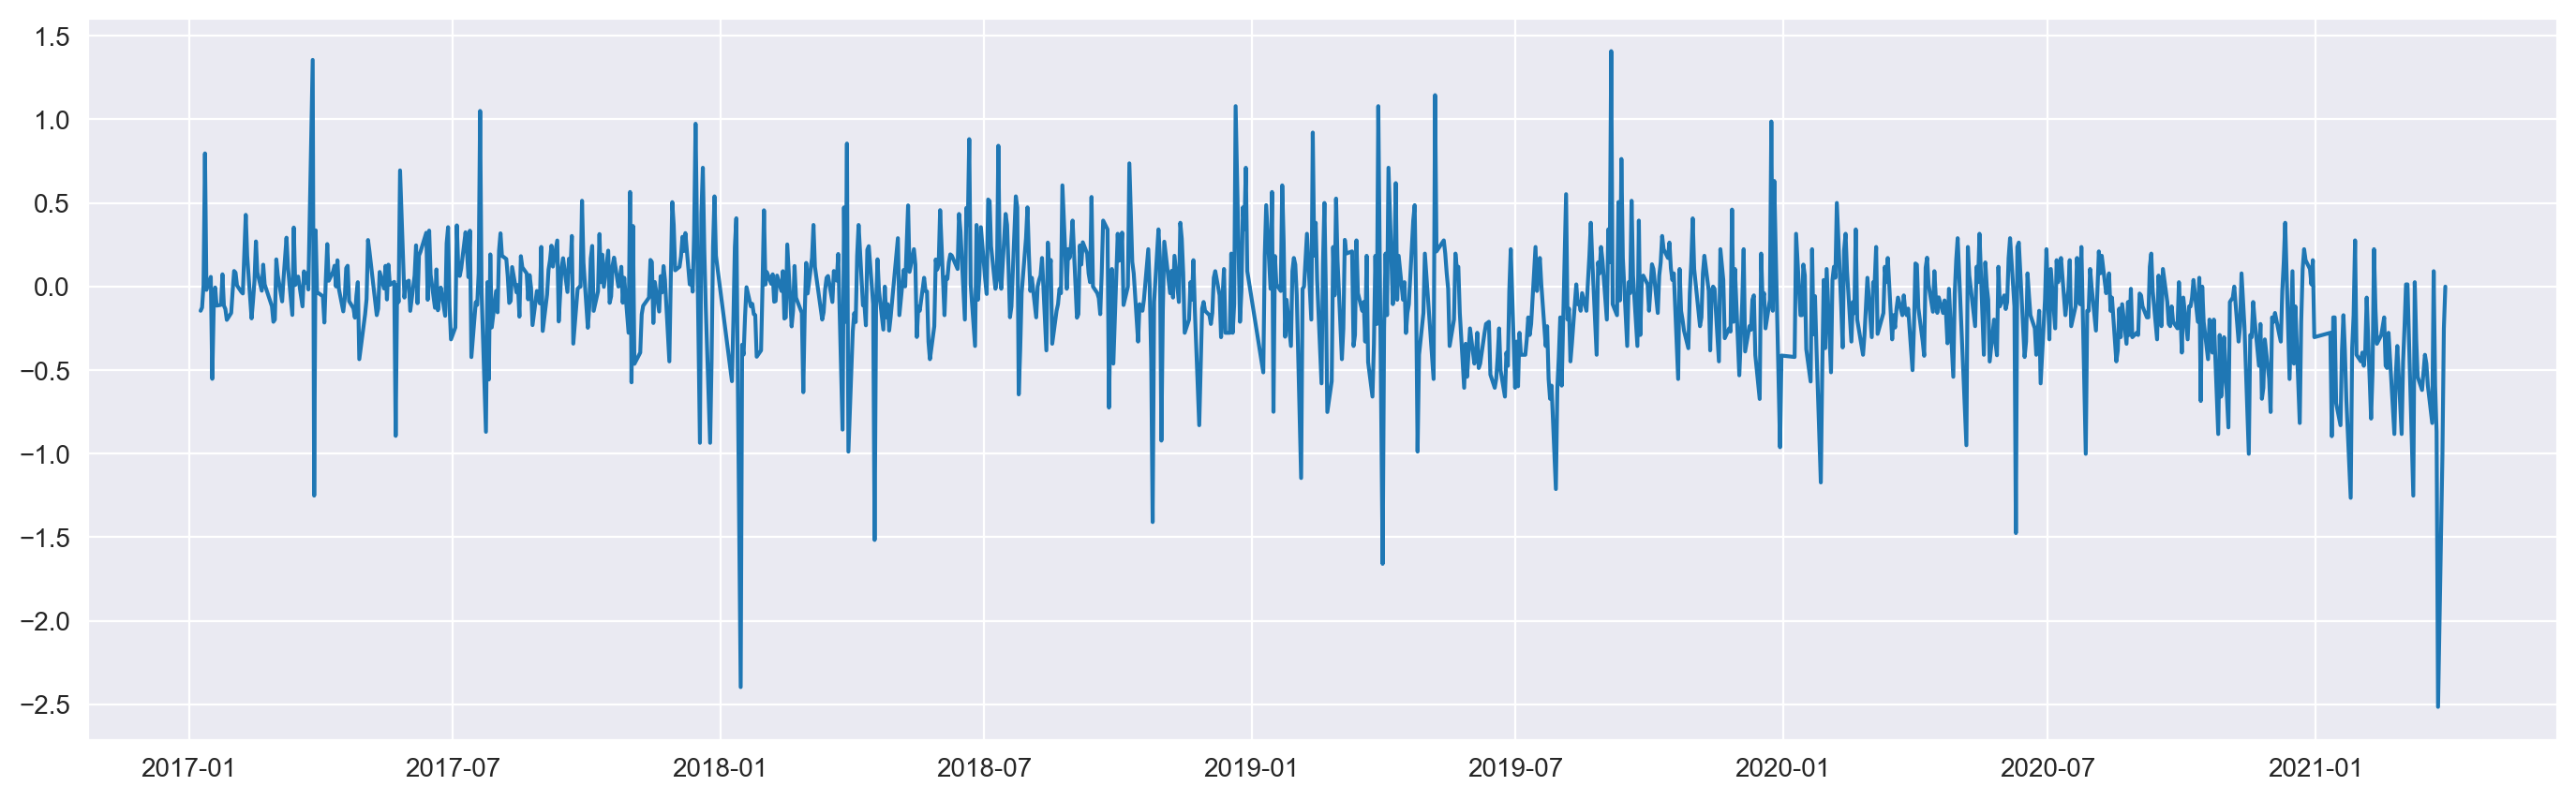

In [7]:
plt.figure(figsize=(17,5))
plt.plot(dataset)
plt.show()

### Визуализация

In [13]:
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, FuncFormatter
import seaborn as sns
from collections import Counter

In [14]:
class AnomalyDetector(object):
    """
    Class which use CUSUM anomaly detection.

    A cumulative sum (CUSUM) chart is a type of control chart used to monitor small shifts in the process mean.

    Parameters
    ----------
    backward_window_size : integer, optional, default 30
        The window size of timeseries for estimate stats (like train)

    forward_window_size : integer, optional, default 14
        The window size of timeseries for compare with backward_window_size (like test)

    threshold : float, optional, default 5.0
        The maximum(minimum, with opposite sign) value of cumulative changes

    drift : float, optional, default 1.0
        The permissible deviation of timeseries from the mean

    Attributes
    ----------
    anomalies_ : timeseries of binary value (with initial timeseries index), where 1 - anomaly, 0 - non-anomaly
    """

    def __init__(self, backward_window_size=30, forward_window_size=14, threshold=5.0, drift=1.0):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift
        self.anomalies_ = None

    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Detect anomaly in one pass

        Parameters
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Train sample to calculate statistics of timeseries

        prediction_zone : pandas.Series or pandas.DataFrame
            Test sample to find anomaly variables

        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`

        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``

        Returns
        -------
        is_fault : binary numpy array, shape = [len(prediction_zone)]
            1 - anomaly, 0 - nonanomaly
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i - 1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i - 1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Detect anomaly in rolling window (=forward_window_size)

        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries

        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`

        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``

        excluded_points : pandas.Series.index
            Acquainted anomaly events. They will be removed from timeseries before anomaly detection

        Returns
        -------
        self.anomalies_ : pandas.Series, shape = [len(time_series)]
            Labeled timeseries with anomaly, where 1 - anomaly, 0 - nonanomaly
        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        self.anomalies_ = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

    def plot(self, time_series, ax=None, figsize=(14, 7),
             xlabel='Дата', ylabel='тысяч рублей', title='Plot Cusum Anomaly Detection',
             grid=True, marketsize=5):
        """
        Plot timeseries with anomaly points

        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries

        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot

        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot

        xlabel : string, optional, default 'Дата'
            Label of x axis

        ylabel : string, optional, default 'тысяч рублей'
            Label of y axis

        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot

        grid : boolean, optional, default True
            If True, use grid at plot

        marketsize : float, optional, default 5
            Size of anomaly points on timeseries plot

        Returns
        -------
        Plot timeseries with anomalies
        """
        anomalies = pd.Series(np.where(self.anomalies_ == 1, time_series, np.nan),
                              index=time_series.index)
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.plot(time_series, label='actual')
        ax.plot(anomalies, 'o', color='r', markersize=marketsize, label='anomalies')
        ax.legend(loc='best')
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    def hist(self, meas='day', th=0.15, ax=None, figsize=(14, 7),
             xlabel='День месяца', ylabel='количество аномалий', title='Hist Cusum Anomaly Detection',
             grid=True):
        """
        Plot hist of anomaly points

        Parameters
        ----------
        meas : pd.datetime attribute, optional, default 'day'

        th : float, optional, default 0.15

        time_series : pandas.Series
            Target timeseries

        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot

        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot

        xlabel : string, optional, default 'День месяца'
            Label of x axis

        ylabel : string, optional, default 'количество аномалий'
            Label of y axis

        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot

        grid : boolean, optional, default True
            If True, use grid at plot

        Returns
        -------
        Plot histogramm of anomalies per month
        """

        idx, anomaly_count, periodic_anomaly_idx = self.__count_anomaly(th, meas)
        simple_color = '#36b2e2'
        anomaly_gradient_colors = dict(zip(periodic_anomaly_idx,
                                           sns.color_palette("Reds", len(periodic_anomaly_idx)).as_hex()[::-1]))
        colors = [simple_color if x[1] / sum(anomaly_count) < th else anomaly_gradient_colors[x[0]]
                  for x in zip(idx, anomaly_count)]
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.set_xlim(0, max(idx))
        ax.set_ylim(0, max(anomaly_count) + 1)
        ax.bar(idx, anomaly_count, color=colors)
        handles = [(x[0], anomaly_gradient_colors[x[0]])
                   for x in zip(idx, anomaly_count) if x[1] / sum(anomaly_count) >= th]
        handles = [mpatches.Patch(color=x[1], label=x[0]) for x in handles]
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.05), fancybox=True, shadow=True)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    def __count_anomaly(self, th, meas):
        anomaly_idx = getattr(self.anomalies_[self.anomalies_ == 1].index, meas)
        count_anomalies_by_idx = sorted(Counter(anomaly_idx).items(), key=lambda x: x[1], reverse=True)
        idx = [x[0] for x in count_anomalies_by_idx]
        anomaly_count = [x[1] for x in count_anomalies_by_idx]
        periodic_anomaly_idx = [x[0] for x in count_anomalies_by_idx if x[1] / len(anomaly_idx) >= th]
        return idx, anomaly_count, periodic_anomaly_idx

    @staticmethod
    def _conf_axs(ax, figsize, xlabel, ylabel, title, grid):
        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        else:
            fig = ax.get_figure()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if grid:
            ax.grid(True)
        return fig, ax


In [15]:
def plot_double(pred, true, roll_days=30):
    
    mae=np.abs(true-pred).shift(1).rolling(roll_days).mean().dropna()
    with plt.style.context('seaborn-white'):
        font = {'family': 'normal','weight': 'bold'}
        plt.rc('font', **font)
        plt.figure(figsize=(17, 12))
        plt.subplots_adjust(wspace=0, hspace=0.4)
        gs = gridspec.GridSpec(5, 1)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1) 
        ax1.plot(pred/1e3, label='Prediction ')
        ax1.plot(true/1e3, label='Actual', color='r')
        ax2.plot(mae, color='#443f3e', label='MAE')
        ax2.set_title('MAE скользящее за {} дней '.format(roll_days), fontweight="bold")
        ax1.set_ylabel('тысяч рублей')


        ax1.legend()
        ax2.legend()
        ax1.grid(True)
        ax2.grid(True)
        plt.show()

In [27]:
detector = AnomalyDetector(backward_window_size=60, forward_window_size=2)
detector.detect(dataset)

Timestamp
2017-01-09    0
2017-01-10    0
2017-01-11    0
2017-01-12    0
2017-01-13    0
             ..
2021-03-25    0
2021-03-26    1
2021-03-29    0
2021-03-30    0
2021-03-31    0
Length: 1041, dtype: int32

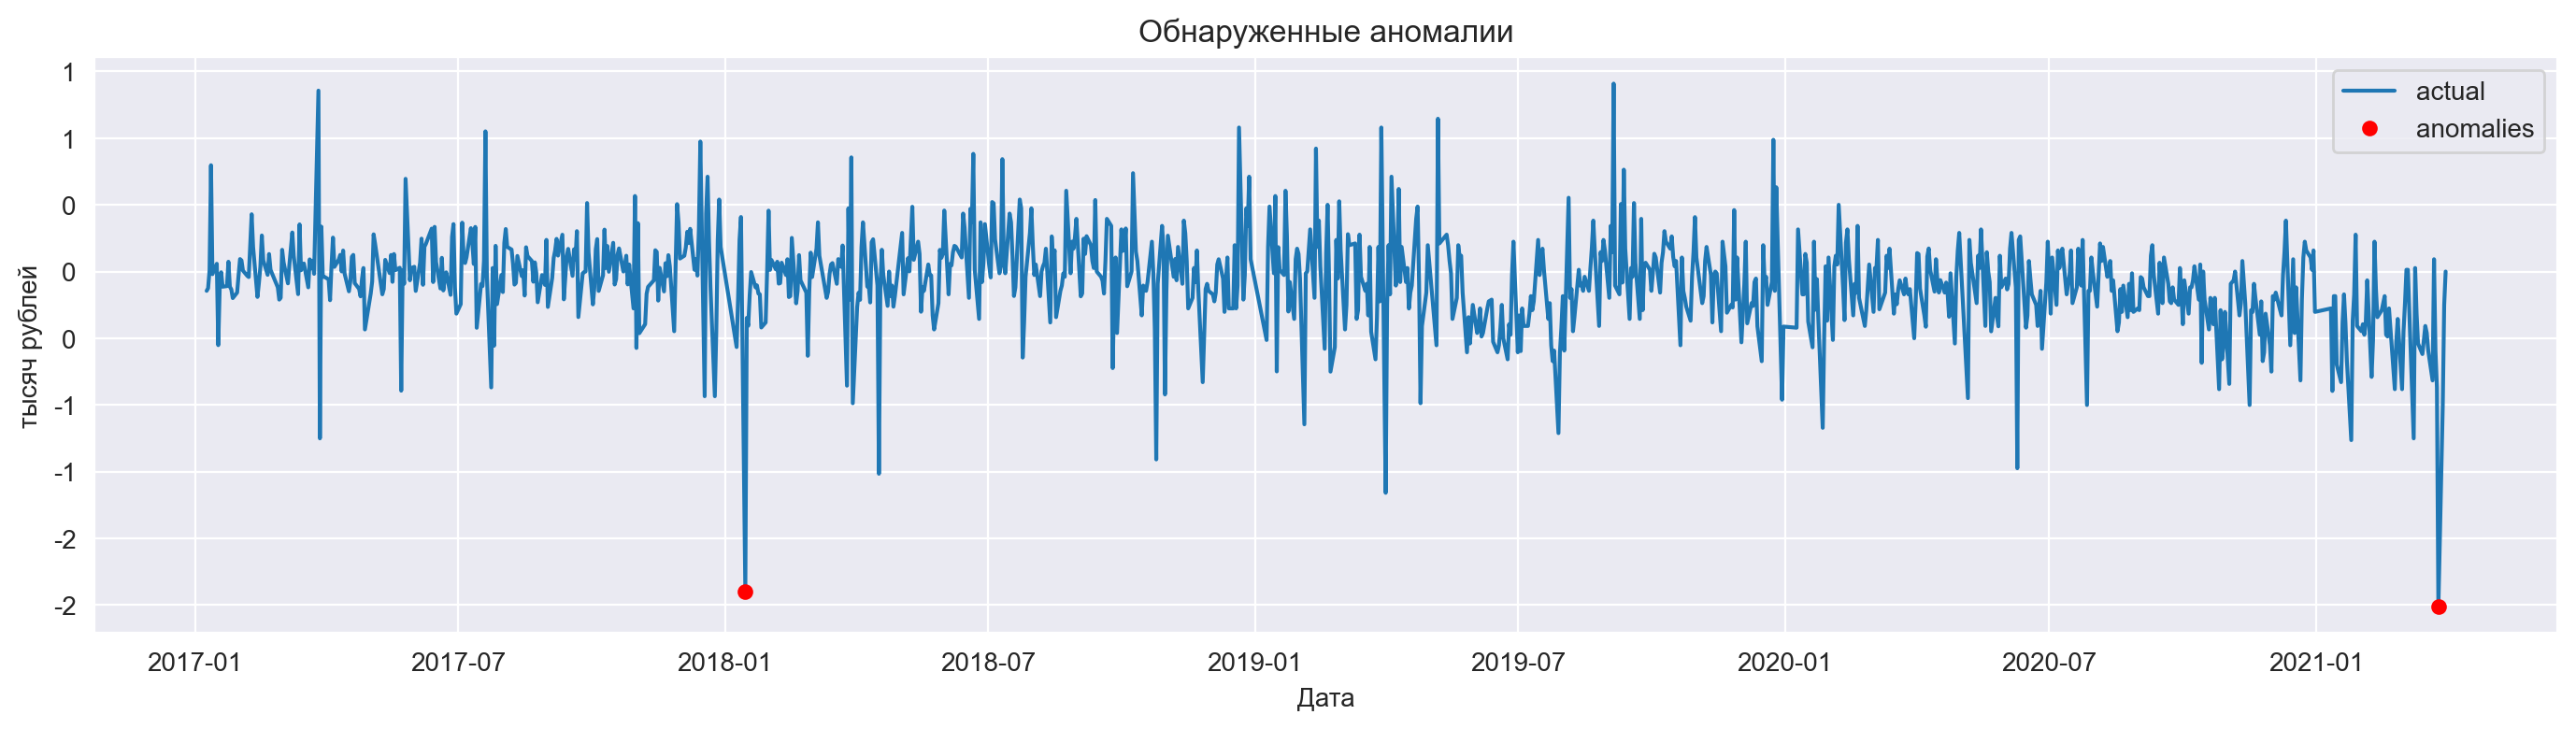

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(17, 4))
plt.subplots_adjust(wspace=0.1)
detector.plot(dataset, ax=ax, title='Обнаруженные аномалии')
plt.show()

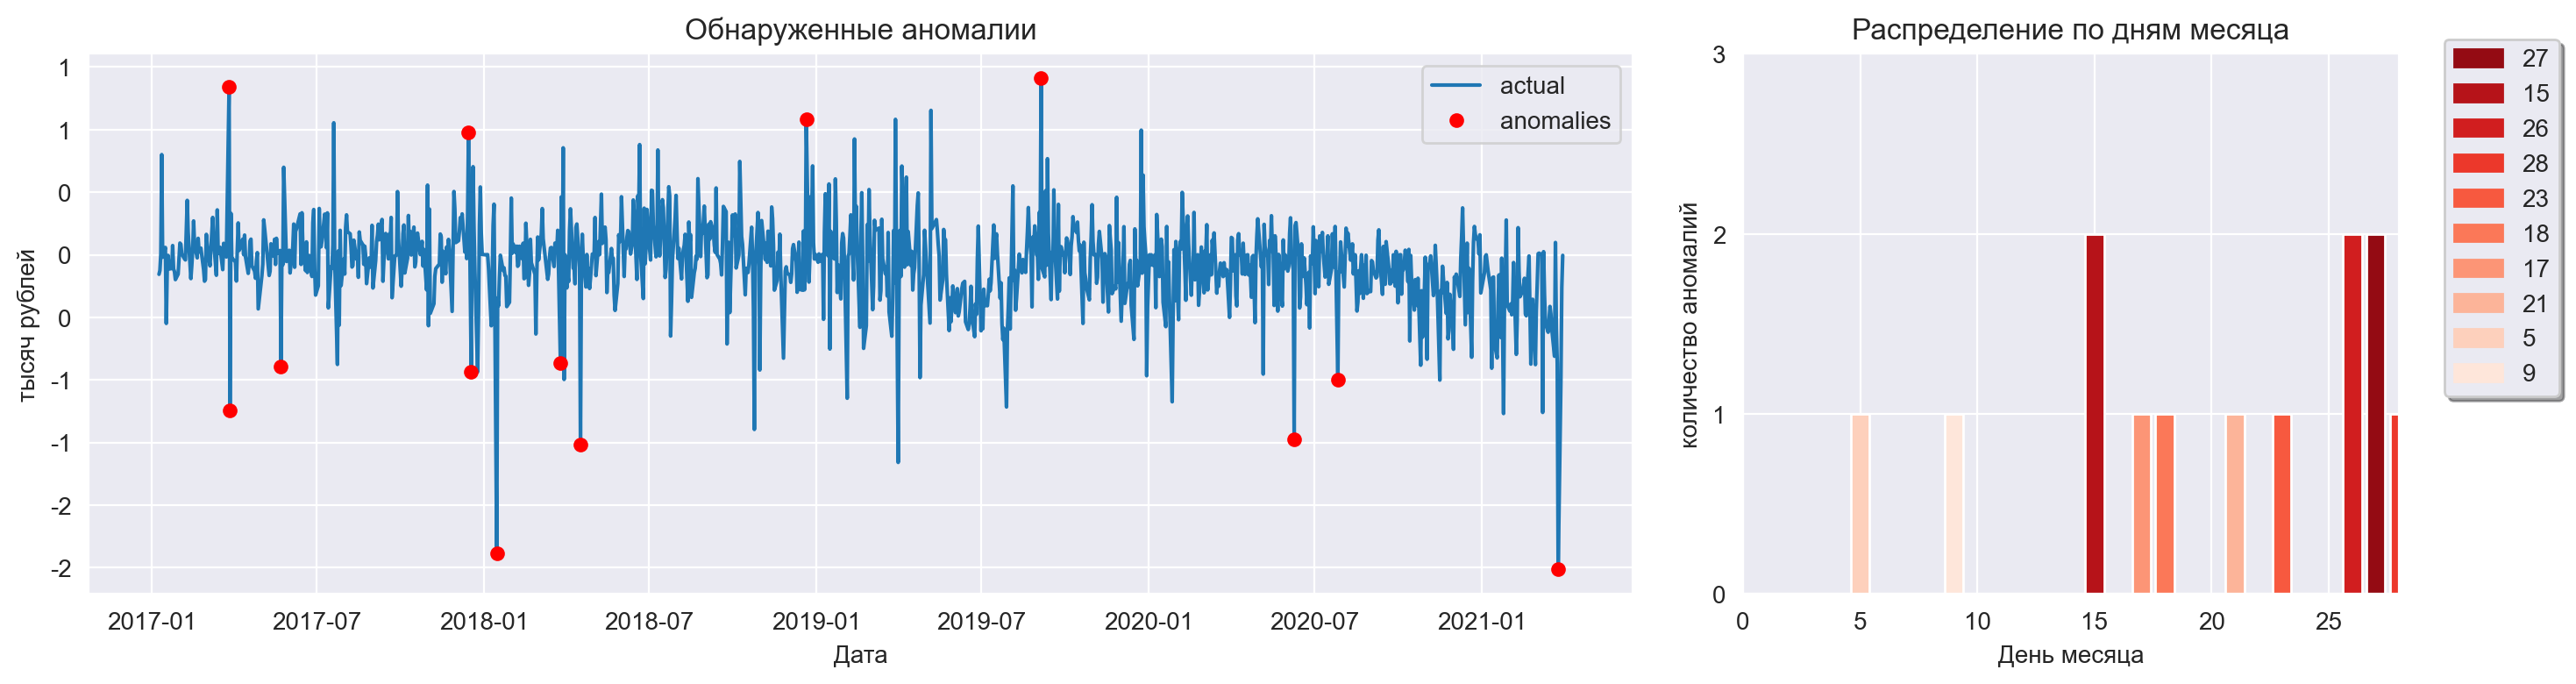

In [18]:
detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(dataset)
fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(dataset, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.02, ax=axs[1], title='Распределение по дням месяца')
plt.show()

In [75]:
#pip install ruptures


In [31]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean().shift(1)
    
    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std().shift(1)
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    
    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series[n+1:], label="Actual values")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.legend(loc="upper left")
    plt.grid(True)

In [32]:
import ruptures as rpt
model = rpt.Binseg(model="l2")  # Поиск разладов в среднем
result = model.fit(np.array(dataset)).predict(pen=2)  # pen — параметр регуляризации
print(f"Точки разлада: {result}")

Точки разлада: [575, 640, 930, 1041]


<Figure size 1440x480 with 0 Axes>

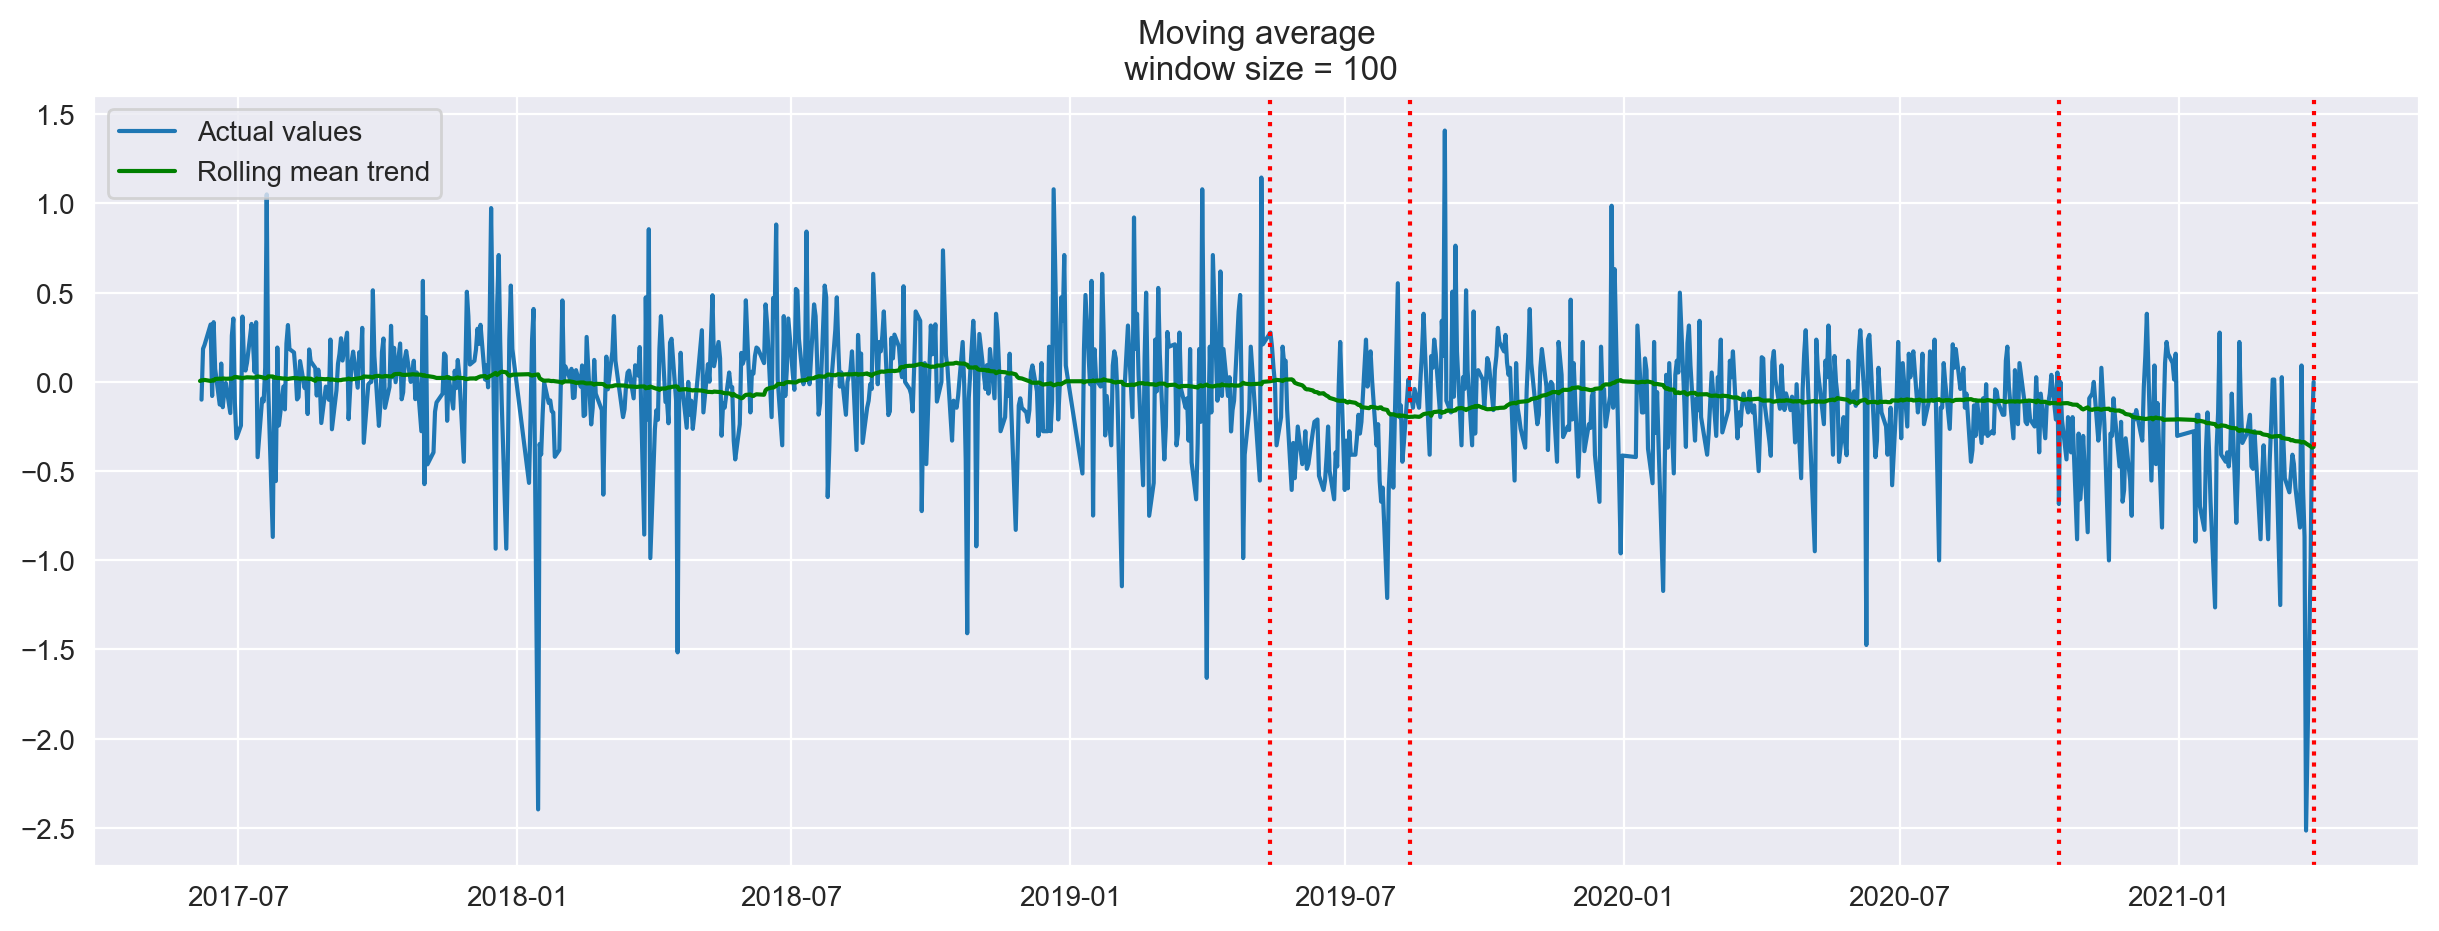

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(18, 6), dpi=80)

plotMovingAverage(dataset, 100)
for br in result:
    plt.axvline(dataset.index[br-1], color='r', linestyle=':', label='Обнаруженная разладка')

In [115]:
import ruptures as rpt
model = rpt.Pelt(model="rbf")  # Поиск разладов в среднем
result = model.fit(np.array(dataset)).predict(pen=2.5)  # pen — параметр регуляризации
print(f"Точки разлада: {result}")

Точки разлада: [205, 600, 655, 945, 990, 1112]


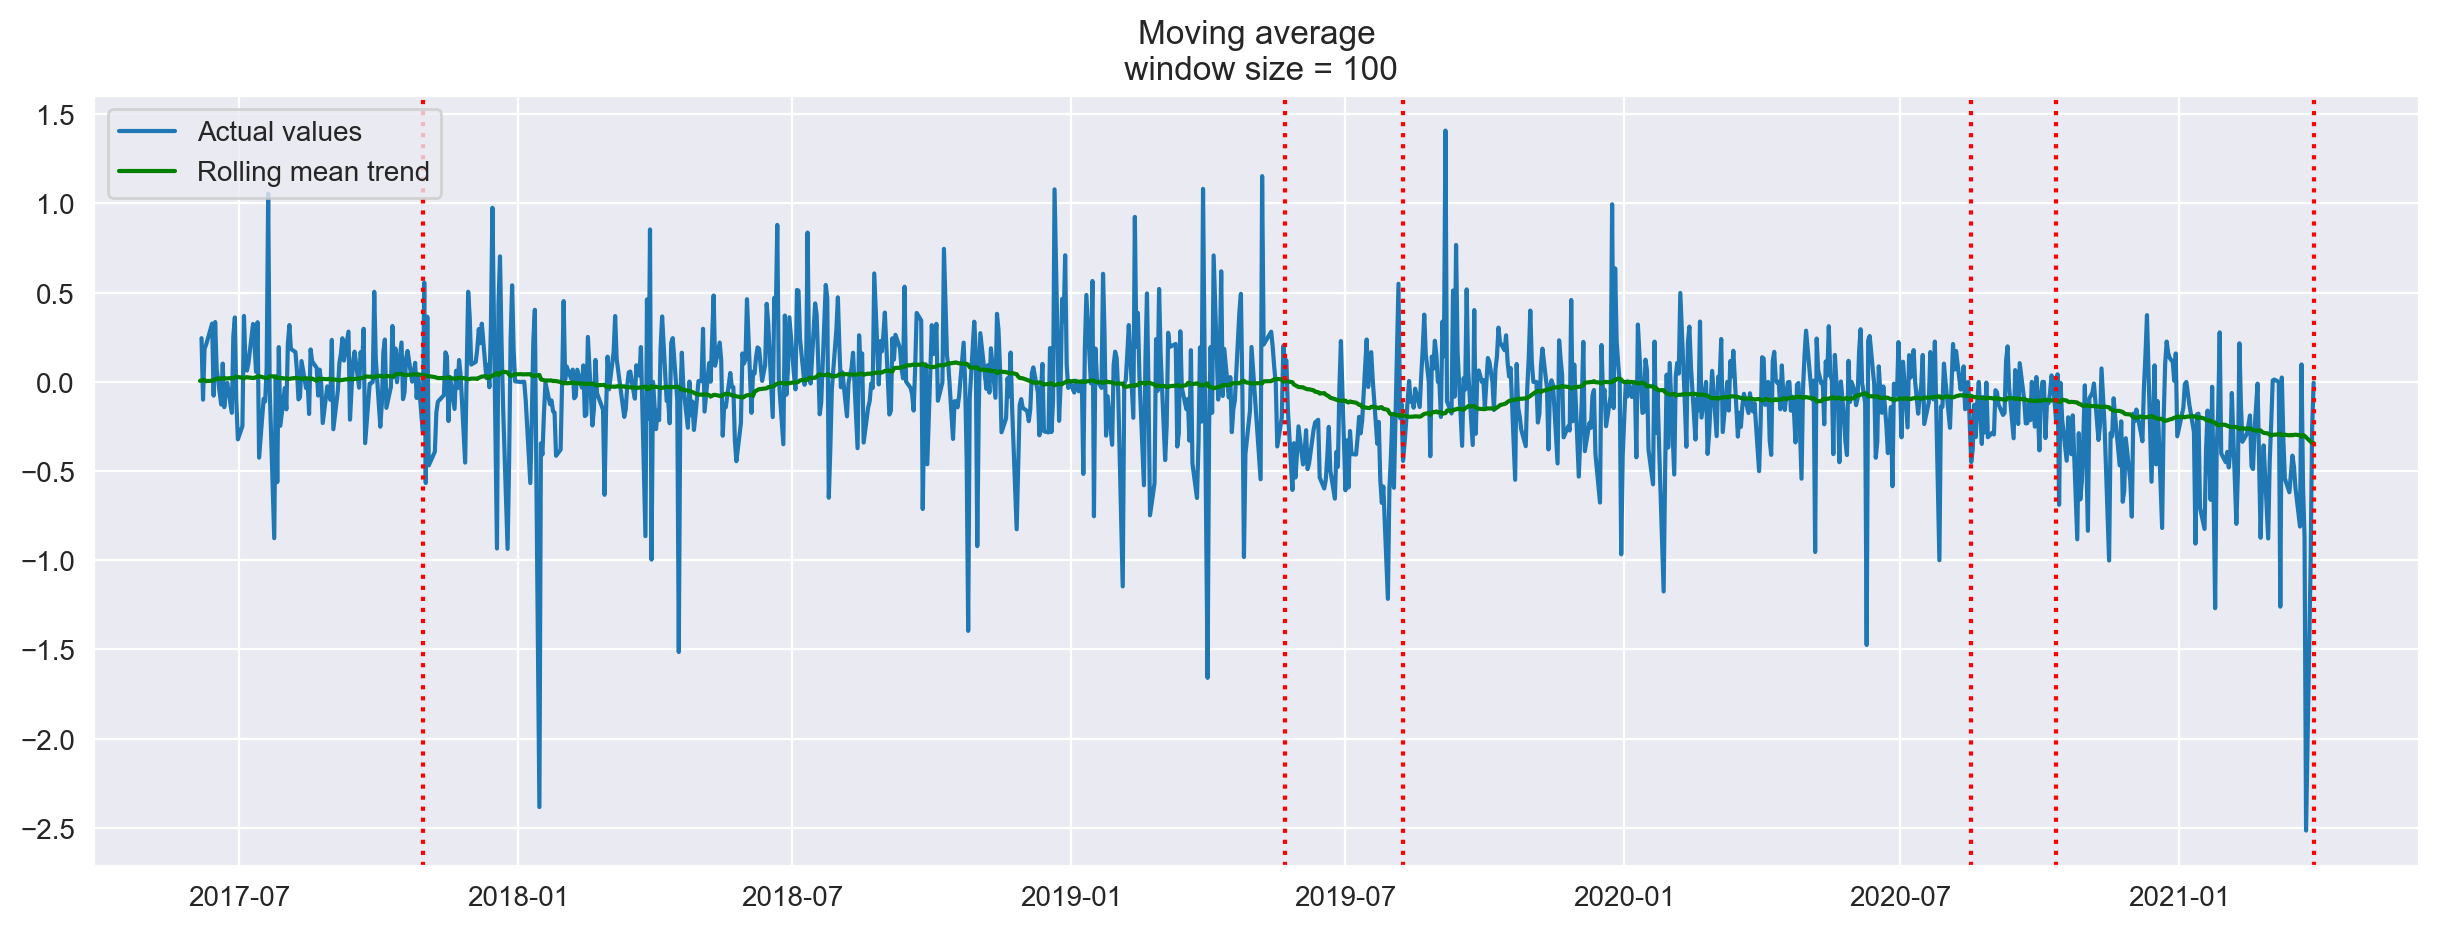

In [116]:
plotMovingAverage(dataset, 100)
for br in result:
    plt.axvline(dataset.index[br-1], color='r', linestyle=':', label='Обнаруженная разладка')